In [31]:
import numpy as np
import pandas as pd
import cv2
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.algorithms.preprocessing import Reweighing

In [32]:
# Load the dataset and create a dataframe with image paths and labels
dataset_path = "data/"
images = []
labels = []
for folder in os.listdir(dataset_path):
    if os.path.isdir(os.path.join(dataset_path, folder)):
        for file in os.listdir(os.path.join(dataset_path, folder)):
            if file.endswith(".jpg"):
                images.append(os.path.join(dataset_path, folder, file))
                labels.append(folder)
df = pd.DataFrame({"image": images, "label": labels})

In [33]:
# Define a function to preprocess the images: resize, grayscale, histogram equalization
def preprocess_image(image_path):
  image = cv2.imread(image_path)
  image = cv2.resize(image, (64, 64))
  image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  image = cv2.equalizeHist(image)
  image = image / 255.0
  image = np.expand_dims(image, axis=2)
  return image

In [34]:
# Apply the preprocessing function to the images and convert the labels to numeric values
X = np.array([preprocess_image(image) for image in df["image"]])
y = np.array([0 if label == "male" else 1 for label in df["label"]])

In [35]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [36]:
# Create a binary label dataset from the train set for aif360
train_df = pd.DataFrame(X_train.reshape(-1, 64*64))
train_df["label"] = y_train
train_df["gender"] = 0
train_dataset = BinaryLabelDataset(favorable_label=1, unfavorable_label=0,
                                   df=train_df,
                                   label_names=["label"],
                                   protected_attribute_names=["gender"],
                                   unprivileged_protected_attributes=[0])


In [37]:
# Compute the disparate impact and statistical parity difference metrics for the train set
metric_dataset = BinaryLabelDatasetMetric(train_dataset,
                                          unprivileged_groups=[{"gender": 0}],
                                          privileged_groups=[{"gender": 1}])
print("Disparate impact:", metric_dataset.disparate_impact())
print("Statistical parity difference:", metric_dataset.statistical_parity_difference())

Disparate impact: nan
Statistical parity difference: nan


/home/megatron/miniconda3/envs/tf/lib/python3.9/site-packages/aif360/metrics/binary_label_dataset_metric.py:105: RuntimeWarning: invalid value encountered in double_scalars
  return (self.num_positives(privileged=privileged)


In [38]:
# Apply the reweighing algorithm to mitigate bias in the train set
RW = Reweighing(unprivileged_groups=[{"gender": 0}], privileged_groups=[{"gender": 1}])
train_dataset_rw = RW.fit_transform(train_dataset)

# Compute the metrics for the reweighted train set
metric_dataset_rw = BinaryLabelDatasetMetric(train_dataset_rw,
                                             unprivileged_groups=[{"gender": 0}],
                                             privileged_groups=[{"gender": 1}])
print("Disparate impact after reweighing:", metric_dataset_rw.disparate_impact())
print("Statistical parity difference after reweighing:", metric_dataset_rw.statistical_parity_difference())


/home/megatron/miniconda3/envs/tf/lib/python3.9/site-packages/aif360/algorithms/preprocessing/reweighing.py:66: RuntimeWarning: invalid value encountered in double_scalars
  self.w_p_fav = n_fav*n_p / (n*n_p_fav)
/home/megatron/miniconda3/envs/tf/lib/python3.9/site-packages/aif360/algorithms/preprocessing/reweighing.py:67: RuntimeWarning: invalid value encountered in double_scalars
  self.w_p_unfav = n_unfav*n_p / (n*n_p_unfav)


Disparate impact after reweighing: nan
Statistical parity difference after reweighing: nan


In [39]:
print(train_dataset_rw.features.shape)
print(train_dataset_rw.features.size)

(37607, 4097)
154075879


In [40]:
# Extract the features and labels from the reweighted train set
X_train_rw = train_dataset_rw.features[:, :-1].reshape(-1, 64, 64, 1)
y_train_rw = train_dataset_rw.labels.ravel()

In [41]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation="relu", input_shape=(64, 64, 1)))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation="relu"))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())

model.add(Dense(256, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(1, activation="sigmoid"))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 62, 62, 32)        320       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 31, 31, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 12, 12, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 6, 6, 128)       

In [42]:
# Compile and fit the model on the reweighted train set
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
early_stopping = EarlyStopping(monitor="val_loss", patience=5)
history = model.fit(X_train_rw, y_train_rw,
                    batch_size=32,
                    epochs=50,
                    validation_split=0.1,
                    callbacks=[early_stopping])

Epoch 1/50
1058/1058 [==============================] - 4s 3ms/step - loss: 0.2663 - accuracy: 0.8862 - val_loss: 0.1717 - val_accuracy: 0.9367
Epoch 2/50
1058/1058 [==============================] - 3s 2ms/step - loss: 0.1645 - accuracy: 0.9396 - val_loss: 0.1526 - val_accuracy: 0.9463
Epoch 3/50
1058/1058 [==============================] - 3s 2ms/step - loss: 0.1388 - accuracy: 0.9487 - val_loss: 0.1423 - val_accuracy: 0.9532
Epoch 4/50
1058/1058 [==============================] - 3s 2ms/step - loss: 0.1228 - accuracy: 0.9553 - val_loss: 0.1849 - val_accuracy: 0.9314
Epoch 5/50
1058/1058 [==============================] - 3s 2ms/step - loss: 0.1078 - accuracy: 0.9610 - val_loss: 0.1440 - val_accuracy: 0.9508
Epoch 6/50
1058/1058 [==============================] - 3s 2ms/step - loss: 0.0953 - accuracy: 0.9651 - val_loss: 0.1454 - val_accuracy: 0.9497
Epoch 7/50
1058/1058 [==============================] - 3s 3ms/step - loss: 0.0846 - accuracy: 0.9691 - val_loss: 0.1727 - val_accuracy:

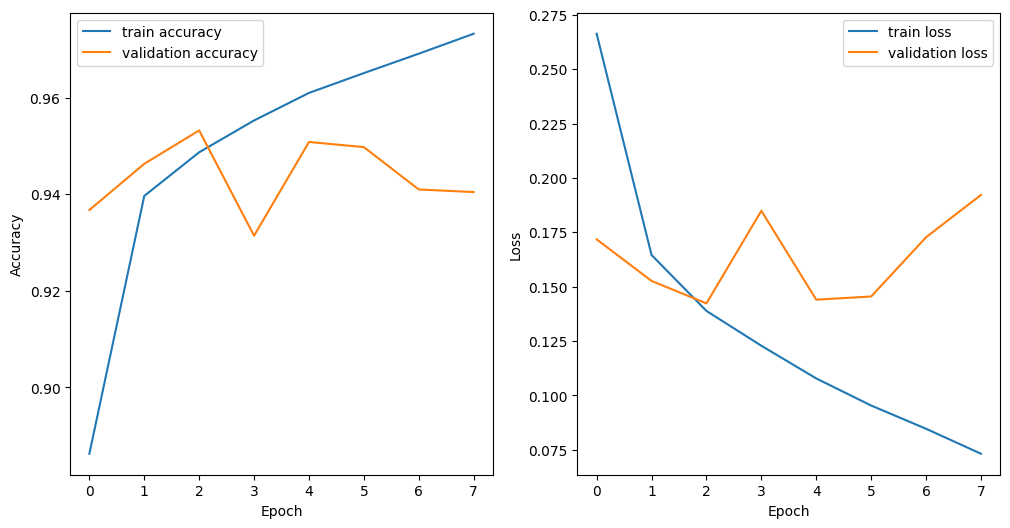

In [43]:
# Plot the training and validation accuracy and loss curves
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(history.history["accuracy"], label="train accuracy")
plt.plot(history.history["val_accuracy"], label="validation accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.subplot(1,2,2)
plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [44]:
# Evaluate the model on the test set
y_pred = model.predict(X_test).round().ravel()
test_acc = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
test_cm = confusion_matrix(y_test, y_pred)
print("Test accuracy:", test_acc)
print("Test Precision:", precision)
print("Test Recall:", recall)
print("Test confusion matrix:")
print(test_cm)

294/294 [==============================] - 0s 734us/step
Test accuracy: 0.9439480961497554
Test Precision: 0.970771001150748
Test Recall: 0.913382416630576
Test confusion matrix:
[[4657  127]
 [ 400 4218]]


In [45]:
# Create a binary label dataset from the test set for aif360
test_df = pd.DataFrame(X_test.reshape(-1, 64*64))
test_df["label"] = y_test
test_df["gender"] = 0
test_dataset = BinaryLabelDataset(favorable_label=1, unfavorable_label=0,
                                   df=test_df,
                                   label_names=["label"],
                                   protected_attribute_names=["gender"],
                                   unprivileged_protected_attributes=[0])

In [46]:
# Compute the classification metrics for the test set
metric_classifier = ClassificationMetric(test_dataset,
                                         test_dataset.copy(),
                                         unprivileged_groups=[{"gender": 0}],
                                         privileged_groups=[{"gender": 1}])
print("Accuracy:", metric_classifier.accuracy())
print("Equal opportunity difference:", metric_classifier.equal_opportunity_difference())
print("Average odds difference:", metric_classifier.average_odds_difference())
print("Theil index:", metric_classifier.theil_index())

Accuracy: 1.0
Equal opportunity difference: nan
Average odds difference: nan
Theil index: 0.0


/home/megatron/miniconda3/envs/tf/lib/python3.9/site-packages/aif360/metrics/classification_metric.py:278: RuntimeWarning: invalid value encountered in double_scalars
  TPR=TP / P, TNR=TN / N, FPR=FP / N, FNR=FN / P,
/home/megatron/miniconda3/envs/tf/lib/python3.9/site-packages/aif360/metrics/classification_metric.py:279: RuntimeWarning: invalid value encountered in double_scalars
  GTPR=GTP / P, GTNR=GTN / N, GFPR=GFP / N, GFNR=GFN / P,


In [47]:
# Compute the classification metrics for the test set
#metric_classifier = ClassificationMetric(test_dataset,
#                                         test_dataset.copy(),
#                                         unprivileged_groups=[{"gender": 0}],
#                                         privileged_groups=[{"gender": 1}])
#print("Balanced accuracy:", metric_classifier.balanced_accuracy())
#print("Equal opportunity difference:", metric_classifier.equal_opportunity_difference())
#print("Average odds difference:", metric_classifier.average_odds_difference())
#print("Theil index:", metric_classifier.theil_index())